In [ ]:
# 1. Imports and helper functions
import json
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskMultiFidelityGP
from botorch.fit import fit_gpytorch_mll
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
FIDELITY_MAP = {
        'y_low': 0.1,    # low fidelity
        'y_medium': 0.5,  # medium fidelity
        'y_high': 0.9,    # high fidelity
    }
# 1) Load data
def load_json_to_df(path: str) -> pd.DataFrame:
    """Load JSON into a DataFrame."""
    with open(path, 'r') as f:
        records = [json.loads(line) for line in f]
    return pd.DataFrame(records)

In [3]:
def find_global_max(func, bounds: np.ndarray, n_restarts: int = 500):
    best_x, best_val = None, -np.inf
    for _ in range(n_restarts):
        x0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
        res = minimize(
            lambda x: -func(x.reshape(1, -1))[0],
            x0,
            bounds=bounds
        )
        val = -res.fun
        if val > best_val:
            best_val, best_x = val, res.x
    return best_x, best_val

In [4]:
def plot_convergence(pred_y, y_train_max, global_max, model_name, out_dir=None):
    """
    Plot the convergence trajectory of Bayesian Optimization.
    """
    plt.figure()
    try:
        mean_y, sem_y = pred_y
        plt.errorbar(
            np.arange(len(mean_y)),
            mean_y,
            yerr=sem_y,
            fmt='-o',
            label="Mean BO ± SEM"
        )
    except Exception:
        plt.plot(pred_y, marker="o", label="BO Guesses")
    plt.axhline(y=y_train_max, color="navy", linestyle="--", label="Train max")
    plt.axhline(y=global_max, color="red", linestyle="-", label="Global max")
    plt.xlabel("Iteration")
    plt.ylabel("Output of Selected x_next")
    plt.title(f"{model_name} Convergence")
    plt.legend()
    plt.tight_layout()
    fig = plt.gcf()
    if out_dir:  # ← EDIT: only save if an out_dir is provided
        os.makedirs(out_dir, exist_ok=True)
        fig.savefig(os.path.join(out_dir, f"convergence_{model_name}.png"))
        plt.close(fig)
    #return fig  # ← EDIT: return the Matplotlib Figure for front-end display

In [5]:
# 2) Assign fidelities
def assign_fidelities(df: pd.DataFrame) -> (np.ndarray, np.ndarray, np.ndarray):
    # Stack embeddings
    X = np.vstack(df['embedding'].values).astype(np.float32)

    # Build Y and F by repeating X for each fidelity
    y_list, f_list = [], []
    for col, fid in FIDELITY_MAP.items():
        # collect the column values
        y_col = df[col].values.astype(np.float32).reshape(-1, 1)
        y_list.append(y_col)
        # assign fidelity index to each row
        f_list.append(np.full((df.shape[0], 1), float(fid), dtype=np.float32))

    # Flatten into single vectors
    Y = np.vstack(y_list).ravel()          # (N * K,)
    F = np.vstack(f_list).ravel()          # (N * K,)
    X_rep = np.vstack([X for _ in FIDELITY_MAP])  # (N * K, D)

    return X_rep, Y, F

In [6]:
# 5. Acquisition helpers
def _predict_with_uncertainty(model, x_cand: np.ndarray):
    x = torch.from_numpy(x_cand).float()
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        post = model.posterior(x)
        mu = post.mean.cpu().numpy().ravel()
        sigma = post.variance.clamp_min(1e-9).sqrt().cpu().numpy().ravel()
    return mu, sigma

def expected_improvement(x_cand, model, y_best, xi=0.01):
    mu, sigma = _predict_with_uncertainty(model, x_cand)
    with np.errstate(divide='warn', invalid='warn'):
        Z = (mu - y_best - xi) / sigma
        ei = (mu - y_best - xi)*norm.cdf(Z) + sigma*norm.pdf(Z)
        ei[sigma==0.0] = 0.0
    return ei

def UCB(x_cand, model, kappa=2.0):
    mu, sigma = _predict_with_uncertainty(model, x_cand)
    return mu + kappa*sigma

def thompson_sampling(x_cand, model):
    mu, sigma = _predict_with_uncertainty(model, x_cand)
    return np.random.normal(mu, sigma)

def gradient_opt(bounds, model, acq_func, n_restarts=10):
    best_x, best_val = None, -np.inf
    for _ in range(n_restarts):
        x0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
        res = minimize(lambda x: -acq_func(x.reshape(1,-1), model)[0], x0, bounds=bounds)
        val = -res.fun
        if val > best_val:
            best_x, best_val = res.x, val
    return best_x

def random_opt(bounds, model, acq_func, n_samples=1000):
    Xcand = np.random.uniform(bounds[:, 0], bounds[:, 1], (n_samples, bounds.shape[0]))
    vals = acq_func(Xcand, model)
    return Xcand[np.argmax(vals)]


In [7]:
# 6. Bayesian Optimization loop
def ground_truth(x: np.ndarray) -> np.ndarray:
    return -np.sum((x - 0.5)**2, axis=1) + np.sin(5 * np.sum(x, axis=1))

def ground_truth2(x: np.ndarray) -> np.ndarray:
    return np.sum(np.sqrt(x) * np.sin(x), axis=1)

In [8]:
# 5) Refactored multi-fidelity BO
def bayes_opt_mf(data_path: str, n_iter: int = 1, acq_func=expected_improvement, acq_opt=gradient_opt) -> tuple[np.ndarray, np.ndarray, list]:
    """
    1) loads JSON at `data_path`
    2) assigns X, Y, F
    3) fits initial multi-fidelity GP
    4) runs `n_iter` BO iterations
    returns updated X, Y, and history list of (x_next, y_next).
    """
    # a) read data
    df = load_json_to_df(data_path)
    X_init, Y_init, F_init = assign_fidelities(df)

    # b) get dims & bounds
    D       = X_init.shape[1]
    bounds  = np.array([[0.0, 1.0]] * D)
    fid_max = max(FIDELITY_MAP.values())

    # c) initial GP fit
    X_aug_init  = np.hstack([X_init, F_init.reshape(-1,1)])
    train_x     = torch.from_numpy(X_aug_init).double()
    train_y     = torch.from_numpy(Y_init).unsqueeze(-1).double()
    fidelity_col = train_x.shape[1] - 1

    surrogate = SingleTaskMultiFidelityGP(
        train_x, train_y, data_fidelities=[fidelity_col]
    )
    mll = ExactMarginalLogLikelihood(surrogate.likelihood, surrogate)
    fit_gpytorch_mll(mll)

    # prepare for loop
    X_data, Y_data, F_data = X_init.copy(), Y_init.copy(), F_init.copy()
    history = []
    y_pred = []

    for it in tqdm(range(n_iter), desc=f"BO iter"):
        # refit GP on all data so far
        X_aug    = np.hstack([X_data, F_data.reshape(-1,1)])
        train_x = torch.from_numpy(X_aug).double()
        train_y = torch.from_numpy(Y_data).unsqueeze(-1).double()
        fidelity_col = train_x.shape[1] - 1

        surrogate = SingleTaskMultiFidelityGP(
            train_x, train_y, data_fidelities=[fidelity_col]
        )
        mll = ExactMarginalLogLikelihood(surrogate.likelihood, surrogate)
        fit_gpytorch_mll(mll)

        # wrap acquisition to highest fidelity
        def wrapped_acq(x_emb, m=surrogate, y_max=Y_data.max()):
            fid_col = np.full((x_emb.shape[0],1), fid_max, dtype=np.float32)
            x_full  = np.hstack([x_emb, fid_col])
            return acq_func(x_full, m, y_max)

        # propose next
        x_next = acq_opt(bounds, surrogate, wrapped_acq)

        # evaluate with ground_truth2
        y_next = ground_truth(x_next.reshape(1,-1))[0]

        # append
        X_data = np.vstack([X_data, x_next])
        Y_data = np.append(Y_data, y_next)
        F_data = np.append(F_data, fid_max)

        history.append((x_next, y_next))
        y_pred.append(y_next)

    return X_data, Y_data, history, y_pred, bounds

BO iter: 100%|██████████| 30/30 [00:31<00:00,  1.07s/it]


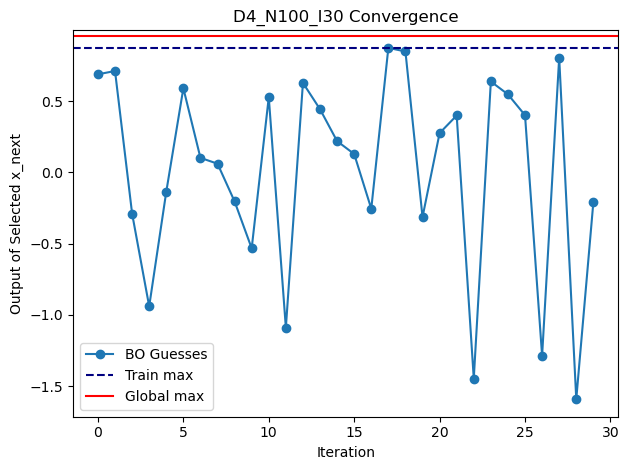

In [12]:
DIM = 4
N_SAMPLES = 100

# Run the BO loop, seeding with the full dataset
X_final, Y_final, History, y_pred, bounds = bayes_opt_mf(f'../data/raw/synth_data/synth_D{DIM}_N{N_SAMPLES}_ground_truth.json',
                                                 30)

y_max = find_global_max(ground_truth, bounds)
plot_convergence(y_pred, np.max(y_pred), y_max[1], f'D{DIM}_N{N_SAMPLES}_I30')